In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#SK-Learn        
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
import time
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
# Any results you write to the current directory are saved as output.

/kaggle/input/factors-affecting-campus-placement/Placement_Data_Full_Class.csv


In [2]:
data = pd.read_csv('/kaggle/input/factors-affecting-campus-placement/Placement_Data_Full_Class.csv', index_col='sl_no')
data.drop('salary', axis=1, inplace=True)
data['status'] = data['status'].map({'Placed':1, 'Not Placed': 0}).astype(int)
data.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
sl_no,,,,,,,,,,,,,
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,1
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,1
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,1
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,0
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 1 to 215
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    object 
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    object 
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    object 
 5   hsc_s           215 non-null    object 
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    object 
 8   workex          215 non-null    object 
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    object 
 11  mba_p           215 non-null    float64
 12  status          215 non-null    int64  
dtypes: float64(5), int64(1), object(7)
memory usage: 23.5+ KB


* No missing values

In [4]:
y = data['status']
X = data.copy()
X.drop('status', axis=1, inplace=True)


# **Splitting into training and test set**

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.16, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((180, 12), (35, 12), (180,), (35,))

* Final accuracy would be checked on Test Dataset(X_test, y_test)
* Cross valiation would be used as dataset is not very big

# **Encoding Categorical Variables**

In [6]:
from sklearn.preprocessing import OneHotEncoder

cols = [ 'gender','ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']
ohc = OneHotEncoder(handle_unknown='ignore', sparse=False)

n_cols_train = pd.DataFrame(ohc.fit_transform(X_train[cols]))
n_cols_test = pd.DataFrame(ohc.transform(X_test[cols]))

n_cols_train.index = X_train.index
n_cols_test.index = X_test.index

n_cols_train.columns = ohc.get_feature_names(cols)
n_cols_test.columns = ohc.get_feature_names(cols)

X_train = pd.concat([X_train, n_cols_train], axis=1)
X_test = pd.concat([X_test, n_cols_test], axis=1)

X_train.drop(cols, axis=1, inplace=True)
X_test.drop(cols, axis=1, inplace=True)

In [7]:
X_train.head()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,gender_F,gender_M,ssc_b_Central,ssc_b_Others,hsc_b_Central,...,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech,workex_No,workex_Yes,specialisation_Mkt&Fin,specialisation_Mkt&HR
sl_no,,,,,,,,,,,,,,,,,,,,,
1,67.00,91.0,58.0,55.00,58.80,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
160,52.00,49.0,58.0,62.00,60.59,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
149,77.00,86.0,56.0,57.00,64.08,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
131,62.00,65.0,60.0,84.00,64.15,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
29,76.76,76.5,67.5,73.35,64.15,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


# **Feature Scaling**

In [8]:
mean = X_train.mean()
std = X_train.std()

In [9]:
print(std,mean)

ssc_p                     11.027370
hsc_p                     11.053859
degree_p                   7.139097
etest_p                   12.990365
mba_p                      5.717089
gender_F                   0.483239
gender_M                   0.483239
ssc_b_Central              0.500279
ssc_b_Others               0.500279
hsc_b_Central              0.487555
hsc_b_Others               0.487555
hsc_s_Arts                 0.218553
hsc_s_Commerce             0.500620
hsc_s_Science              0.495291
degree_t_Comm&Mgmt         0.466474
degree_t_Others            0.229700
degree_t_Sci&Tech          0.440466
workex_No                  0.481662
workex_Yes                 0.481662
specialisation_Mkt&Fin     0.499410
specialisation_Mkt&HR      0.499410
dtype: float64 ssc_p                     67.168667
hsc_p                     66.481167
degree_p                  66.201611
etest_p                   71.917722
mba_p                     62.177111
gender_F                   0.366667
gender_M     

In [10]:
X_train = (X_train-mean)/std
X_test = (X_test-mean)/std

In [11]:
X_train.head(3)

,ssc_p,hsc_p,degree_p,etest_p,mba_p,gender_F,gender_M,ssc_b_Central,ssc_b_Others,hsc_b_Central,...,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech,workex_No,workex_Yes,specialisation_Mkt&Fin,specialisation_Mkt&HR
sl_no,,,,,,,,,,,,,,,,,,,,,
1,-0.015295,2.218124,-1.148830,-1.302329,-0.590705,-0.758769,0.758769,-1.066071,1.066071,-0.786237,...,-0.228778,0.943274,-0.852473,-1.464891,-0.241861,1.677518,0.749718,-0.749718,-1.090175,1.090175
160,-1.375547,-1.581454,-1.148830,-0.763468,-0.277608,-0.758769,0.758769,0.932812,-0.932812,-0.786237,...,-0.228778,0.943274,-0.852473,0.678852,-0.241861,-0.592807,0.749718,-0.749718,-1.090175,1.090175
149,0.891539,1.765794,-1.428978,-1.148368,0.332842,1.310602,-1.310602,0.932812,-0.932812,1.264816,...,4.346774,-1.054248,-0.852473,-1.464891,4.111637,-0.592807,0.749718,-0.749718,0.912188,-0.912188


# **Model Selection**

In [12]:


models = pd.DataFrame(columns=['model', 'score', 'std','Time to Train']) #DataFrame to store scores of all models

options = [GaussianNB(), 
           LogisticRegression(), 
           SVC(), 
           LinearSVC(), 
           DecisionTreeClassifier(), 
           RandomForestClassifier(), 
           KNeighborsClassifier(), 
           SGDClassifier(), 
           XGBClassifier()]   

model_names = ['Naive Bayes', 
               'Logistic Regression', 
               'Support Vector Machine', 
               'Linear SVC', 
               'Decison Tree',
               'Random Forest',
               'KNN', 
               'SGD Classifier',
               'XGBoost']  

for (opt, name) in zip(options, model_names):
    start=time.time()
    model = opt
    model.fit(X_train, y_train)
    
    scores = cross_val_score(model, X_train, y_train, cv = 5, scoring="accuracy")
    end=time.time()
    row = pd.DataFrame([[name, scores.mean(), scores.std(), end-start]], columns=['model', 'score', 'std','Time to Train'])
    models = pd.concat([models, row], ignore_index=True)

models.sort_values(by='score', ascending=False)

,model,score,std,Time to Train
5,Random Forest,0.855556,0.032394,0.816696
3,Linear SVC,0.850000,0.062361,0.047086
1,Logistic Regression,0.844444,0.057198,0.043834
2,Support Vector Machine,0.822222,0.064788,0.023103
8,XGBoost,0.822222,0.051520,0.175759
4,Decison Tree,0.811111,0.064310,0.017130
7,SGD Classifier,0.811111,0.040825,0.017617
0,Naive Bayes,0.794444,0.054433,0.019655
6,KNN,0.750000,0.039284,0.027763


1. Random Forest is the best model on the basis of accuracy
2. Std deviation of Random Forest classifier is the best among all as well.

In [13]:
rf = RandomForestClassifier(random_state = 3, oob_score=True)
rf.fit(X_train, y_train)
print("OOB Score: ", rf.oob_score_)

OOB Score:  0.8611111111111112


# **Feature Engineering**

In [14]:
model = RandomForestClassifier(random_state = 3)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [15]:
rfe = RFE(model, n_features_to_select=1, verbose =3)
rfe.fit(X_train,y_train)

imp1 = pd.DataFrame({'feature':X_train.columns, 'rank1':rfe.ranking_})
imp1 = imp1.sort_values(by = 'rank1')
imp1

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


,feature,rank1
0,ssc_p,1
1,hsc_p,2
4,mba_p,3
2,degree_p,4
3,etest_p,5
20,specialisation_Mkt&HR,6
18,workex_Yes,7
17,workex_No,8
5,gender_F,9
19,specialisation_Mkt&Fin,10


In [16]:
imp2= pd.DataFrame({'featur':X_train.columns, 'importance':np.round(model.feature_importances_, 3)})
imp2['rank2'] = imp2['importance'].rank(ascending=False, method='min')
imp2 = imp2.sort_values(by = 'importance', ascending=False)
imp2

,featur,importance,rank2
0,ssc_p,0.291,1.0
1,hsc_p,0.169,2.0
2,degree_p,0.152,3.0
4,mba_p,0.092,4.0
3,etest_p,0.086,5.0
19,specialisation_Mkt&Fin,0.019,6.0
18,workex_Yes,0.019,6.0
20,specialisation_Mkt&HR,0.019,6.0
17,workex_No,0.018,9.0
7,ssc_b_Central,0.016,10.0


* We will combine the above two feature importances and sort on the basis or rank.

In [17]:
# importances['rank']=importances2['rank'].values
# importances=importances.sort_values('rank')
# importances

imp = pd.concat([imp1, imp2], axis=1)
imp['rank'] = imp['rank1'] + imp['rank2']
imp = imp.sort_values(by = 'rank')
imp = imp.drop(['featur', 'importance', 'rank1', 'rank2'], axis=1)
imp

,feature,rank
0,ssc_p,2.0
1,hsc_p,4.0
2,degree_p,7.0
4,mba_p,7.0
3,etest_p,10.0
20,specialisation_Mkt&HR,12.0
18,workex_Yes,13.0
19,specialisation_Mkt&Fin,16.0
17,workex_No,17.0
7,ssc_b_Central,21.0


In [18]:
X_temp = X_train[imp.feature]

* Determing optimal number of features

In [19]:
features = [i for i in range(22)]
results = []

for i in features:
    rf = RandomForestClassifier(n_jobs=-1, random_state=3)
    cols = X_temp.columns[:i+1]
    X_t = X_temp[cols]
    scores = cross_val_score(rf, X_t, y_train, cv = 5, scoring="accuracy")
    results.append(scores.mean())
    print(i, " : ", np.round(scores.mean(),3), np.round(scores.std(),3))

0  :  0.783 0.079
1  :  0.822 0.022
2  :  0.856 0.054
3  :  0.872 0.028
4  :  0.867 0.032
5  :  0.872 0.028
6  :  0.878 0.045
7  :  0.883 0.054
8  :  0.889 0.053
9  :  0.872 0.038
10  :  0.867 0.041
11  :  0.878 0.048
12  :  0.878 0.042
13  :  0.867 0.032
14  :  0.872 0.042
15  :  0.861 0.035
16  :  0.872 0.038
17  :  0.85 0.028
18  :  0.85 0.033
19  :  0.872 0.028
20  :  0.85 0.033
21  :  0.85 0.033


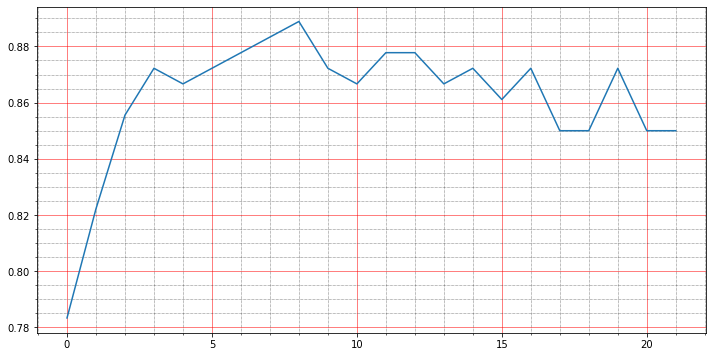

In [20]:
fig, ax = plt.subplots(figsize=(12,6))

ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

sns.lineplot(y = results, x = features)

* Optimal number of features comes out to be 8
* Making dataset using the optimal number of features

In [21]:
n_f = 8
to_keep = X_temp.columns[:n_f+1]
X_train_fimp = X_train[to_keep]
X_test_fimp = X_test[to_keep]
X_train_fimp.head()

,ssc_p,hsc_p,degree_p,mba_p,etest_p,specialisation_Mkt&HR,workex_Yes,specialisation_Mkt&Fin,workex_No
sl_no,,,,,,,,,
1,-0.015295,2.218124,-1.148830,-0.590705,-1.302329,1.090175,-0.749718,-1.090175,0.749718
160,-1.375547,-1.581454,-1.148830,-0.277608,-0.763468,1.090175,-0.749718,-1.090175,0.749718
149,0.891539,1.765794,-1.428978,0.332842,-1.148368,-0.912188,-0.749718,0.912188,0.749718
131,-0.468713,-0.133995,-0.868683,0.345086,0.930095,-0.912188,-0.749718,0.912188,0.749718
29,0.869775,0.906365,0.181870,0.345086,0.110257,-0.912188,1.326424,0.912188,-1.326424


* Checking OOB Score for new dataframe

In [22]:
rf = RandomForestClassifier(random_state=3, oob_score=True)
rf.fit(X_train_fimp, y_train)
rf.oob_score_

0.8666666666666667

* The new dataset performs better than the original dataset.
* Hence new one is kept as the final dataset

In [23]:
X_train_final = X_train_fimp
X_test_final = X_test_fimp

# **Performing Hyperparameter Tuning**
The current parameters(SK-Learn defaults) are as follows:

In [24]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 3,
 'verbose': 0,
 'warm_start': False}


* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

In [25]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,'none']
}
pprint(param_grid)

{'max_depth': [4, 5, 6, 7, 8, 'none'],
 'max_features': ['auto', 'sqrt', 'log2'],
 'n_estimators': [200, 500]}


In [26]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# Fit the random search model
CV_rfc.fit(X_train_final, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [27]:
CV_rfc.best_params_

{'max_depth': 7, 'max_features': 'auto', 'n_estimators': 200}

In [28]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=7, criterion='entropy')
rfc1.fit(X_train_final, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [29]:
pred=rfc1.predict(X_test_final)
print("Accuracy for Random Forest after Hyperparameter Tuning on test data: ",accuracy_score(y_test,pred))
pred=rf.predict(X_test_final)
print("Accuracy for Random Forest before Hyperparameter Tuning on test data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest after Hyperparameter Tuning on test data:  0.8285714285714286
Accuracy for Random Forest before Hyperparameter Tuning on test data:  0.7714285714285715


# Saving as a pickle file

In [30]:
import pickle

In [31]:
Pkl_Filename = "Pickle_rfc_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(rfc1, file)

Testing the same

In [32]:
with open(Pkl_Filename, 'rb') as file:  
    Pickled_Model = pickle.load(file)

Pickled_Model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [33]:
score = Pickled_Model.score(X_test_fimp, y_test)  

print("Test score: {0:.2f} %".format(100 * score))  


Ypredict = Pickled_Model.predict(X_test_fimp)  

Ypredict

Test score: 82.86 %


array([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1])

Same result shows that model is saved and retrieved successfully 

# Model Hosting
Please the below link to the web app where the model is hosted https://intense-castle-03852.herokuapp.com/